In [47]:
# Import libraries.
using Turing, StatsPlots, Random, Memoization, StatsBase, Statistics

In [2]:
using ProgressMeter


In [3]:
N = 10000
INFALG = IS()
PRIOR_POLICY = [1,1,1]
PDIRAC = 0.95

0.95

In [4]:
function winning(opp_move)
    best_moves = Dict(1 => 2, 2 => 3, 3 => 1)
    move = best_moves[opp_move]
    return move
end

winning (generic function with 1 method)

In [5]:
@model function agent(opponent_chn, opponent_history, opp_prior_policy = [1,1,1], depth = 1)
    beta_opp ~ Dirichlet(opp_prior_policy) #prior
    if depth == -1 # the simplest agent
        opponent_history = []
    end
    if depth <= 0
        for i in 1:length(opponent_history)
            opponent_history[i] ~ Categorical(beta_opp) # observe
        end
        next_opp_move ~ Categorical(beta_opp) # sample
    end
    if depth > 0
        weights = exp.(opponent_chn[:lp][:, 1])
        idx ~ Categorical(weights/sum(weights))
        opp_move_sample = opponent_chn[:my_move][idx, 1]
        
        # init alternative way to Dirac distribution
        complete_p_dirac = (1 - PDIRAC) / 2
        phi = fill(complete_p_dirac, 3)
        phi[convert(Int, opp_move_sample)] = PDIRAC
        
        next_opp_move ~ Categorical(phi) # observe
    end
    winning_move = winning(next_opp_move)
    
    # init alternative way to Dirac distribution
    complete_p_dirac = (1 - PDIRAC) / 2
    phi = fill(complete_p_dirac, 3)
    phi[convert(Int,winning_move)] = PDIRAC
    
    my_move ~ Categorical(phi) # Dirac(next_opp_move) / observe(next_opponent_move, infered_opponent_move)
end

agent (generic function with 3 methods)

In [6]:
# Plot the results
function plotChn(chn)
    histogram(chn[:my_move], weights=exp.(chn[:lp]), normalize=:probability)
end

plotChn (generic function with 1 method)

In [7]:
function run_two_agents_theory_of_mind(my_model, other_model, opponent_prior, my_prior , opponent_history, my_history, depth, show_progress = true)
    second_chn_i = []
    first_chn_i = []
    p = Progress(depth)
    if depth == -1
        first_chn_i = sample(my_model(second_chn_i, my_history, my_prior, -1),  INFALG, N , progress = false)
        second_chn_i = sample(other_model(first_chn_i, opponent_history, opponent_prior, -1), INFALG, N , progress = false) 
    end 
    for i in 0:depth
        first_chn_i = sample(my_model(second_chn_i, my_history, my_prior, i),  INFALG, N , progress = false)
        second_chn_i = sample(other_model(first_chn_i, opponent_history, opponent_prior, i), INFALG, N , progress = false)
        if show_progress
            ProgressMeter.next!(p)
        end
    end
    return second_chn_i
end

run_two_agents_theory_of_mind (generic function with 2 methods)

## Depth 0

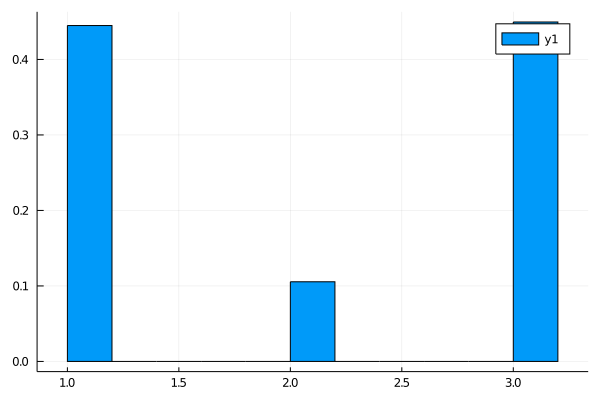

In [8]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,9,2], [], [], -1))

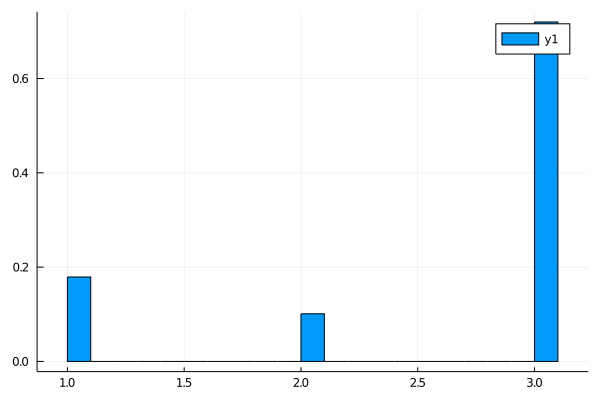

In [9]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,9,2] , [1,9,2], [], [], -1))

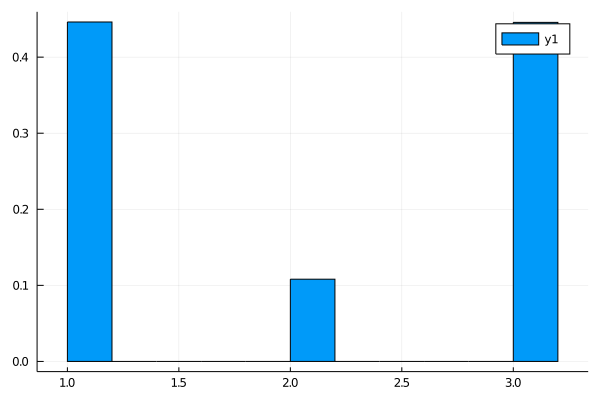

In [10]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 0))

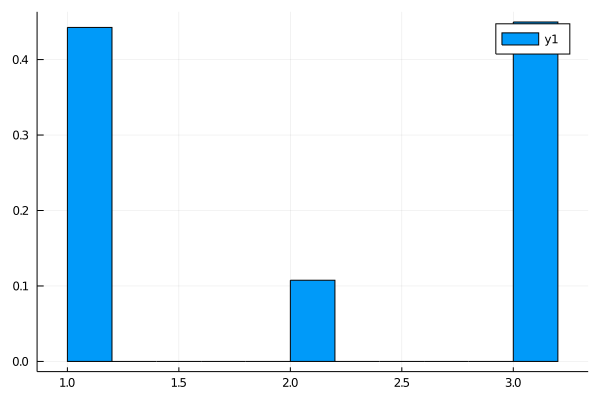

In [11]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 0))

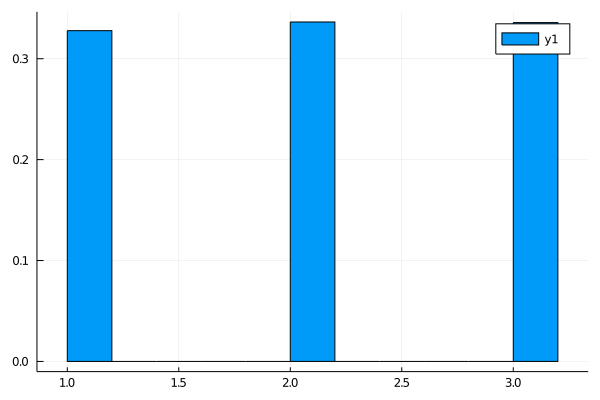

In [12]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 0))

## Depth 3

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


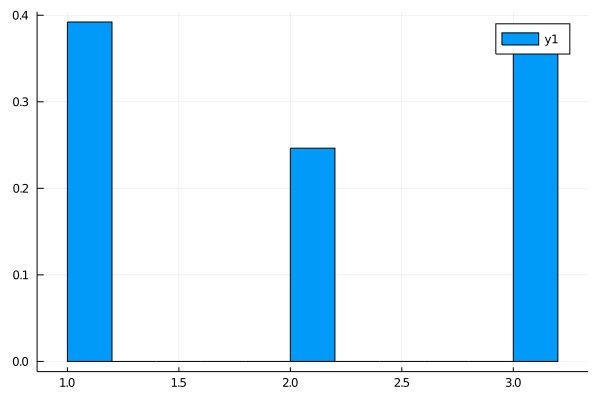

In [13]:
plotChn(run_two_agents_theory_of_mind(agent, agent,[1,5,5], [1,1,1], [], [], 3))

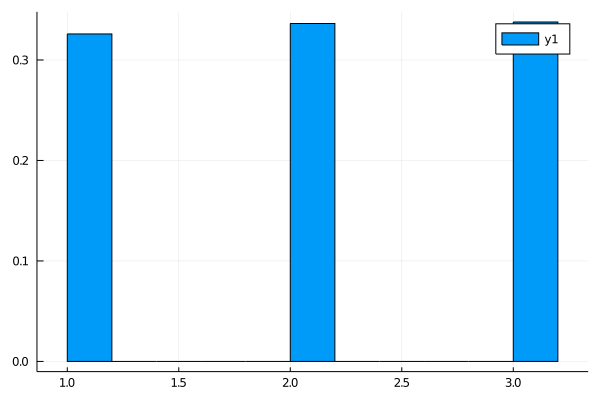

In [14]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 3,false))

## Depth 10

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


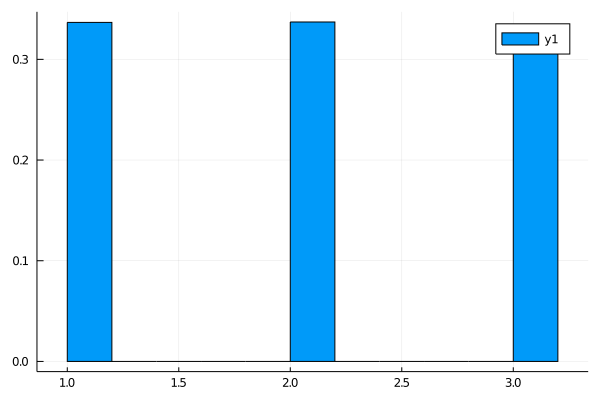

In [15]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5], [1,1,1], [], [], 10))

Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


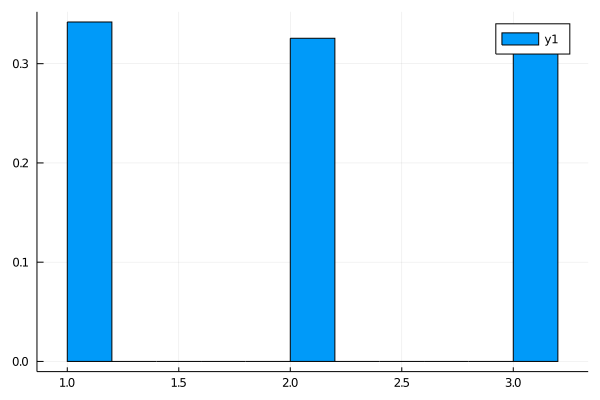

In [16]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 10))

## Depth 20

Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


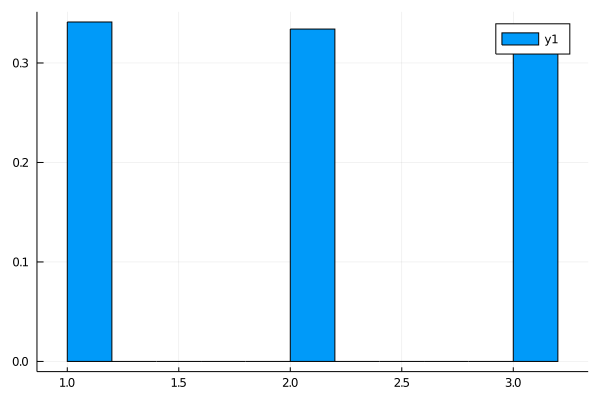

In [17]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,5,5] , [1,1,1], [], [], 20))

Progress: 100%|█████████████████████████████████████████| Time: 0:02:51


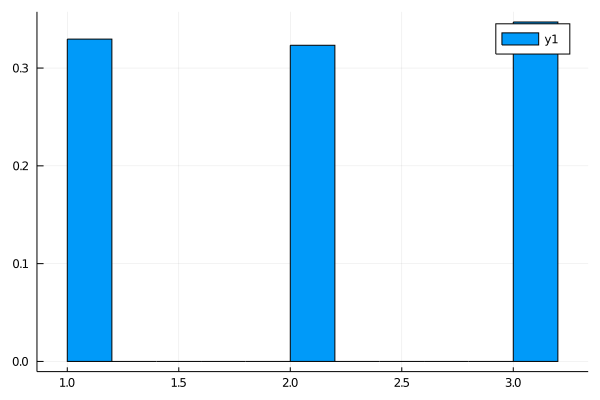

In [18]:
plotChn(run_two_agents_theory_of_mind(agent, agent, [1,1,1], [1,5,5], [], [], 20))

# Simulations

In [19]:
function sample_move(chn)
    weights = exp.(chn[:lp][:, 1])
    weights = Weights(weights/sum(weights))
    idx = sample(collect(1:length(weights)), weights)
    move_sample = chn[:my_move][idx, 1]
    return move_sample
end

sample_move (generic function with 1 method)

In [20]:
function move(agent, other_agent, other_agent_history, my_history, other_player_prior, my_depth=1)
    other_agent_history = length(other_agent_history) > 0 ? other_agent_history : [1]
    other_agent_history = Array{Int}(other_agent_history)
    my_history = length(my_history) > 0 ? my_history : [1]
    my_history = Array{Int}(my_history)
    m = agent(other_agent, other_agent_history, other_player_prior, my_depth)
    chain = run_two_agents_theory_of_mind(agent, other_agent, other_player_prior, [1,1,1] , other_agent_history, my_history, my_depth, false)
    return sample_move(chain)
end

move (generic function with 2 methods)

In [60]:
function game(first_player_depth = 1, second_player_depth = 1, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1])
    first_player = agent
    second_player = agent
    num_of_rounds = 20
    first_player_history = []
    second_player_history = []
    
    @showprogress for i in 1:num_of_rounds
        m1 = move(first_player, second_player, second_player_history, first_player_history, second_player_prior_policy, first_player_depth)
        push!(first_player_history, m1)
        m2 = move(second_player, first_player, first_player_history, second_player_history, first_player_prior_policy, second_player_depth)
        push!(second_player_history, m2)
    end
    return first_player_history, second_player_history
 end

game (generic function with 5 methods)

In [52]:
function score(history)
    first_player_history, second_player_history = history
    first_wins = 0
    ties = 0
    second_wins = 0
    wins = Dict(1 => 3, 2 => 1, 3 => 2)
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            second_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            first_wins += 1
        else
            ties += 1
        end
    end
    return [first_wins, ties, second_wins]
end

score (generic function with 1 method)

In [23]:
function accumulated_score(history)
    first_player_history, second_player_history = history
    first_wins, ties, second_wins = 0, 0, 0
    acc_result = []
    wins = Dict(1 => 3, 2 => 1, 3 => 2)
    for i in 1:length(first_player_history)
        if wins[first_player_history[i]] == second_player_history[i]
            second_wins += 1
        elseif wins[second_player_history[i]] == first_player_history[i]
            first_wins += 1
        else
            ties += 1
        end
        push!(acc_result, [first_wins, ties, second_wins])
    end
    return acc_result
end

accumulated_score (generic function with 1 method)

In [24]:
function plot_accumulated_score(acc_result)
    n = length(acc_result)
    acc_result = transpose(reduce(hcat, acc_result))
    plot(1:n, acc_result, alpha = 0.3)
end

plot_accumulated_score (generic function with 1 method)

In [25]:
function display_score(score)
    num_of_wins_first, num_of_ties, num_of_wins_second = score
    println("first player won: $num_of_wins_first")
    println("second player won: $num_of_wins_second") 
    println("ties: $num_of_ties") 
end

display_score (generic function with 1 method)

In [58]:
NUM_OF_EXPIREMENTS = 10

10

In [50]:
function mean_and_var(results)
    results = reduce(hcat, results)
    mean_results = mean(results,dims=2)
    var_results = std(results,dims=2)
    return mean_results , var_results
end

mean_and_var (generic function with 1 method)

In [56]:
function simulate_game(first_player_depth = 1, second_player_depth = 1, first_player_prior_policy = [1,1,1] , second_player_prior_policy = [1, 1, 1], num_of_expirements = 10)
    plt = plot()
    scores = []
    for i in 1:num_of_expirements
        game_result = game(first_player_depth,second_player_depth, first_player_prior_policy, second_player_prior_policy)
        acc_result = accumulated_score(game_result)
        score_result = score(game_result)
        push!(scores,score_result)
        n = length(acc_result)
        acc_result = transpose(reduce(hcat, acc_result))
        plot!(acc_result, alpha = 0.3, legend = false, label = ["p1 wins" "ties" "p2 wins"] , color = [1 2 3])
    end
    display(plt)
    mean_results, var_results = mean_and_var(scores)
    println("first win: $(mean_results[1])+-$(var_results[1])")
    println("ties: $(mean_results[2])+-$(var_results[2])")
    println("second win: $(mean_results[3])+-$(var_results[3])")
end 

simulate_game (generic function with 6 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:04
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:02
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:17
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


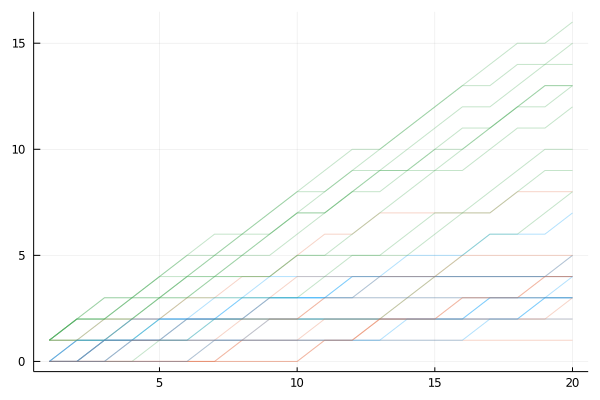

first win: 3.8+-1.3984117975602022
ties: 3.9+-1.9119507199599983
second win: 12.3+-2.5841396591085743


In [61]:
simulate_game(-1, -1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
Progress: 100%|█████████████████████████████████████████| Time: 0:01:13
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:02
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:02
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


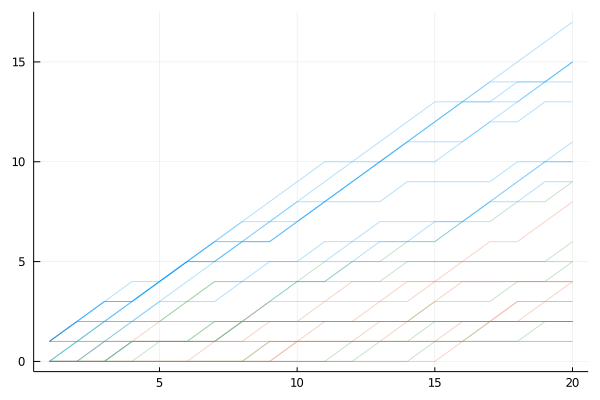

first win: 12.9+-2.726414006223804
ties: 3.5+-1.9002923751652299
second win: 3.6+-2.547329756605707


In [62]:
simulate_game(-1, -1, [10,1,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11
Progress: 100%|█████████████████████████████████████████| Time: 0:01:12
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


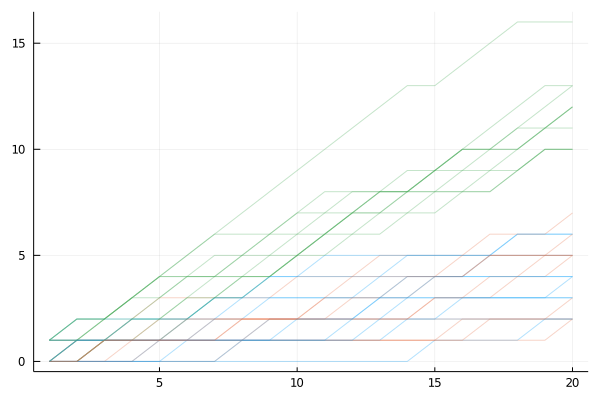

first win: 3.9+-1.449137674618944
ties: 4.2+-1.8135294011647258
second win: 11.9+-1.8529256146249728


In [63]:
simulate_game(0, -1, [1,10,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


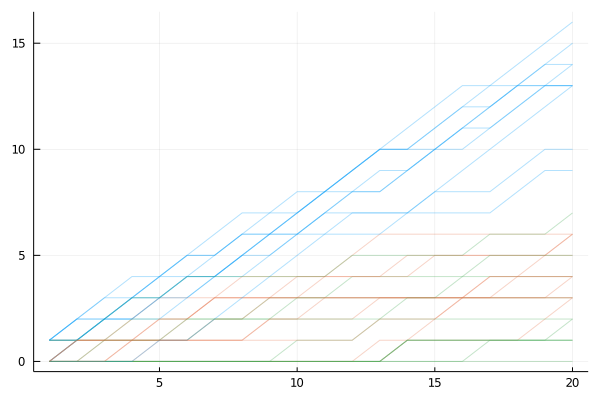

first win: 13.0+-2.1081851067789197
ties: 4.4+-1.2649110640673515
second win: 2.6+-2.1705094128132942


In [64]:
simulate_game(-1, 0, [10,1,1], [1,1,10], NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:23
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:17
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


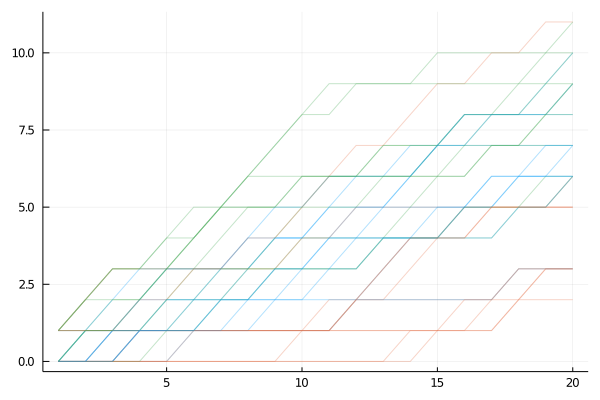

first win: 6.9+-1.911950719959998
ties: 4.6+-2.590581230363393
second win: 8.5+-1.7159383568311666


In [65]:
simulate_game(0, 0, [1,10,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


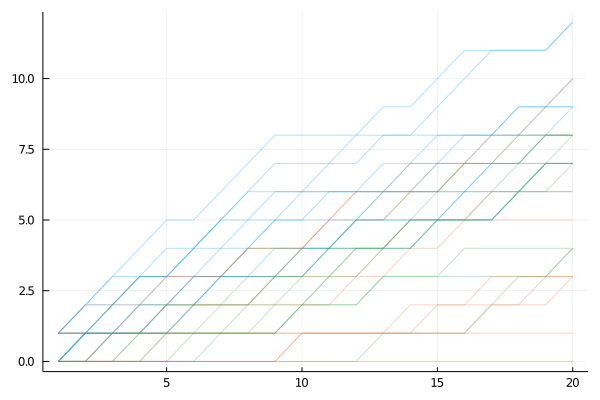

first win: 8.9+-2.024845673131659
ties: 4.6+-3.169297153067923
second win: 6.5+-1.7795130420052185


In [66]:
simulate_game(0, 0, [10,1,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:27
Progress: 100%|█████████████████████████████████████████| Time: 0:03:28
Progress: 100%|█████████████████████████████████████████| Time: 0:03:25
Progress: 100%|█████████████████████████████████████████| Time: 0:03:27
Progress: 100%|█████████████████████████████████████████| Time: 0:03:25
Progress: 100%|█████████████████████████████████████████| Time: 0:03:26
Progress: 100%|█████████████████████████████████████████| Time: 0:03:24
Progress: 100%|█████████████████████████████████████████| Time: 0:03:27
Progress: 100%|█████████████████████████████████████████| Time: 0:03:26
Progress: 100%|█████████████████████████████████████████| Time: 0:03:28


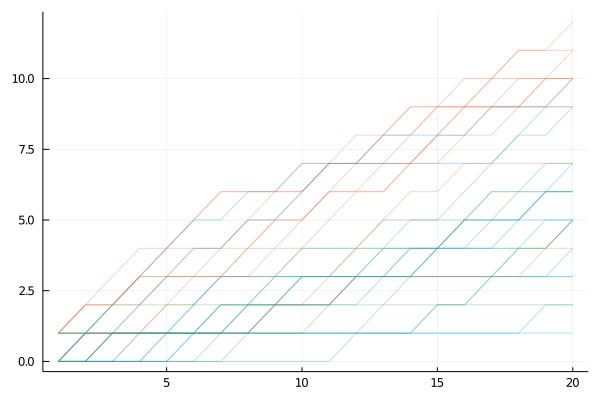

first win: 5.1+-2.960855732160327
ties: 9.4+-2.3190036174568114
second win: 5.5+-1.8408935028645435


In [67]:
simulate_game(0, 1, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:27
Progress: 100%|█████████████████████████████████████████| Time: 0:03:26
Progress: 100%|█████████████████████████████████████████| Time: 0:03:29
Progress: 100%|█████████████████████████████████████████| Time: 0:03:27
Progress: 100%|█████████████████████████████████████████| Time: 0:03:27
Progress: 100%|█████████████████████████████████████████| Time: 0:03:28
Progress: 100%|█████████████████████████████████████████| Time: 0:03:28
Progress: 100%|█████████████████████████████████████████| Time: 0:03:29
Progress: 100%|█████████████████████████████████████████| Time: 0:03:26
Progress: 100%|█████████████████████████████████████████| Time: 0:03:28


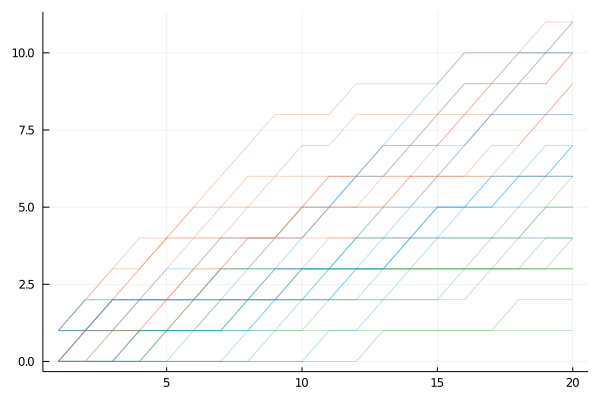

first win: 7.6+-2.170509412813294
ties: 8.8+-2.2509257354845507
second win: 3.6+-1.5055453054181618


In [68]:
simulate_game(1, 0, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:05:39
Progress: 100%|█████████████████████████████████████████| Time: 0:05:41
Progress: 100%|█████████████████████████████████████████| Time: 0:05:39
Progress: 100%|█████████████████████████████████████████| Time: 0:05:38
Progress: 100%|█████████████████████████████████████████| Time: 0:05:39
Progress: 100%|█████████████████████████████████████████| Time: 0:05:39
Progress: 100%|█████████████████████████████████████████| Time: 0:05:37
Progress: 100%|█████████████████████████████████████████| Time: 0:05:39
Progress: 100%|█████████████████████████████████████████| Time: 0:05:51
Progress: 100%|█████████████████████████████████████████| Time: 0:05:39


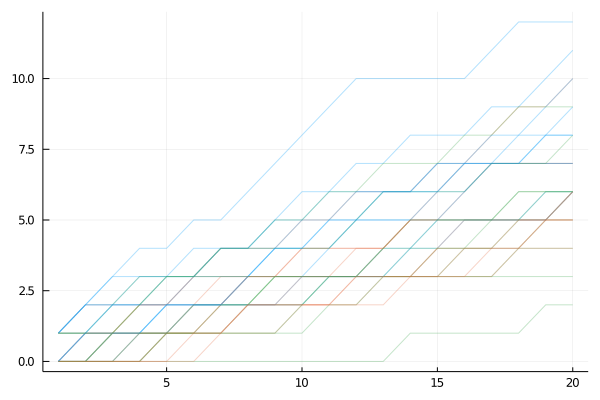

first win: 8.4+-2.0655911179772892
ties: 6.1+-1.6633299933166203
second win: 5.5+-2.1213203435596424


In [69]:
simulate_game(1, 1, [10,1,1] , [1, 1, 10],NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:05:37
Progress: 100%|█████████████████████████████████████████| Time: 0:05:37
Progress: 100%|█████████████████████████████████████████| Time: 0:05:39
Progress: 100%|█████████████████████████████████████████| Time: 0:05:38
Progress: 100%|█████████████████████████████████████████| Time: 0:05:37
Progress: 100%|█████████████████████████████████████████| Time: 0:05:38
Progress: 100%|█████████████████████████████████████████| Time: 0:05:39
Progress: 100%|█████████████████████████████████████████| Time: 0:05:39
Progress: 100%|█████████████████████████████████████████| Time: 0:05:40
Progress: 100%|█████████████████████████████████████████| Time: 0:05:37


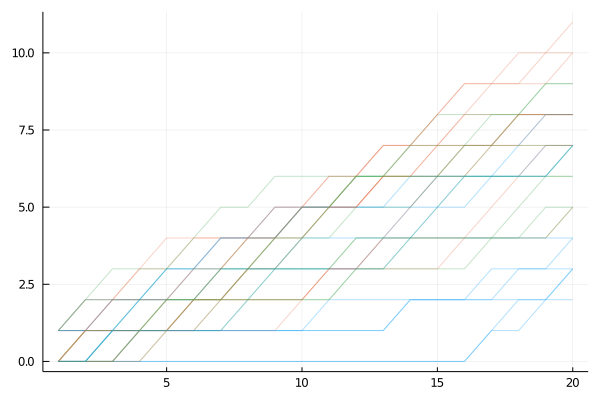

first win: 4.8+-2.2010098692292237
ties: 8.2+-1.7511900715418263
second win: 7.0+-1.4907119849998598


In [70]:
simulate_game(1, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:07:36
Progress: 100%|█████████████████████████████████████████| Time: 0:07:39
Progress: 100%|█████████████████████████████████████████| Time: 0:07:38
Progress: 100%|█████████████████████████████████████████| Time: 0:07:39
Progress: 100%|█████████████████████████████████████████| Time: 0:07:35
Progress: 100%|█████████████████████████████████████████| Time: 0:07:36
Progress: 100%|█████████████████████████████████████████| Time: 0:07:36
Progress: 100%|█████████████████████████████████████████| Time: 0:07:36
Progress: 100%|█████████████████████████████████████████| Time: 0:07:39
Progress: 100%|█████████████████████████████████████████| Time: 0:07:36


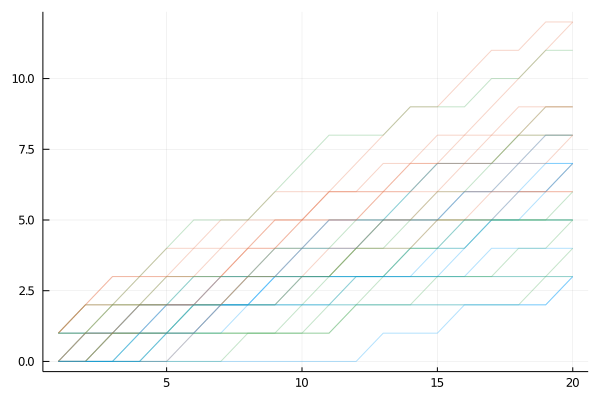

first win: 5.4+-2.011080417199781
ties: 8.5+-2.1213203435596424
second win: 6.1+-2.4698178070456938


In [71]:
simulate_game(2, 1, [1,10,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

Progress: 100%|█████████████████████████████████████████| Time: 0:07:37
Progress: 100%|█████████████████████████████████████████| Time: 0:07:36
Progress: 100%|█████████████████████████████████████████| Time: 0:07:38
Progress: 100%|█████████████████████████████████████████| Time: 0:07:36
Progress: 100%|█████████████████████████████████████████| Time: 0:07:36
Progress: 100%|█████████████████████████████████████████| Time: 0:07:38
Progress: 100%|█████████████████████████████████████████| Time: 0:07:36
Progress: 100%|█████████████████████████████████████████| Time: 0:07:36
Progress: 100%|█████████████████████████████████████████| Time: 0:07:36
Progress: 100%|█████████████████████████████████████████| Time: 0:07:37


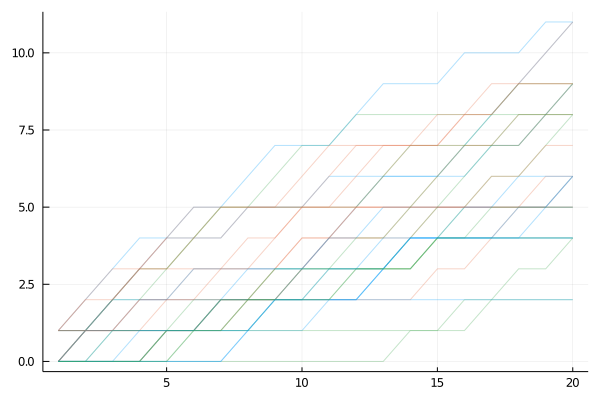

first win: 6.4+-3.0258148581093907
ties: 7.5+-2.0138409955990952
second win: 6.1+-2.5582111805799856


In [72]:
simulate_game(1, 2, [10,1,1], [1,1,10] ,NUM_OF_EXPIREMENTS)

## Summery
* The history overwrite the prior pretty fast when looking on history
* when adding theory of mind from 0 to 1 the player succeed to exploit the inbalanced prior
* when going towards higher depth's we see that the effect above not working anymore (but the result is going to Nash-EQ). need more expirments
* we need to see how larger then 1 difference in theory of mind parameter affect the results

TODO:
* increase the num of rounds
* adding more example with different levels of theory of mind (2,0) , (0, 2)